In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json

join = os.path.join
from tqdm import tqdm
from skimage import transform
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import monai
import torch.nn.functional as F
import argparse
import random
from datetime import datetime
import shutil
import glob

In [2]:
from typing import Tuple, List, Union, Optional

In [3]:
import sys
sys.path.append('/mnt/parscratch/users/acs23yz/MedSAM/')

from segment_anything import sam_model_registry

In [4]:
import socket
print("Current Node:", socket.gethostname())

Current Node: node002.pri.stanage.alces.network


In [5]:
all4_file_path = '/mnt/parscratch/users/acs23yz/MedSAM/data/npy/all_Brain/'
all4_file_list = os.listdir(all4_file_path)

In [6]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2)
    )

In [8]:
class NpyDataset(Dataset):
    def __init__(self, data_root, epsilon, adv_method, bbox_shift=20):
        self.data_root = data_root
        self.gt_path = join(data_root, "gts")
        self.img_path = join(data_root, f'{adv_method}/eps={epsilon}/')
        self.gt_path_files = sorted(
            glob.glob(join(self.gt_path, "**/*.npy"), recursive=True)
        )
        self.gt_path_files = [
            file
            for file in self.gt_path_files
            if os.path.isfile(join(self.img_path, os.path.basename(file)))
        ]
        self.bbox_shift = bbox_shift
        print(f"number of images: {len(self.gt_path_files)}")

    def __len__(self):
        return len(self.gt_path_files)

    def __getitem__(self, index):
        # load npy image (1024, 1024, 3), [0,1]
        img_name = os.path.basename(self.gt_path_files[index])
        img_1024 = np.load(
            join(self.img_path, img_name), "r", allow_pickle=True
        )  # (4, 1024, 1024)
        img_1024 = (img_1024 - img_1024.min()) / np.clip(
                    img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
                )  # normalize to [0, 1]
        
        assert (
            np.max(img_1024) <= 1.0 and np.min(img_1024) >= 0.0
        ), "image should be normalized to [0, 1]"
        gt = np.load(
            self.gt_path_files[index], "r", allow_pickle=True
        )  # multiple labels [0, 1,4,5...], (256,256)
        assert img_name == os.path.basename(self.gt_path_files[index]), (
            "img gt name error" + self.gt_path_files[index] + self.npy_files[index]
        )
        label_ids = np.unique(gt)[1:]
        gt2D = np.uint8(
            gt == random.choice(label_ids.tolist())
        )  # only one label, (256, 256)
        assert np.max(gt2D) == 1 and np.min(gt2D) == 0.0, "ground truth should be 0, 1"
        y_indices, x_indices = np.where(gt2D > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = gt2D.shape
        x_min = max(0, x_min - random.randint(0, self.bbox_shift))
        x_max = min(W, x_max + random.randint(0, self.bbox_shift))
        y_min = max(0, y_min - random.randint(0, self.bbox_shift))
        y_max = min(H, y_max + random.randint(0, self.bbox_shift))
        bboxes = np.array([x_min, y_min, x_max, y_max])
        return (
            torch.tensor(img_1024).float(),
            torch.tensor(gt2D[None, :, :]).long(),
            torch.tensor(bboxes).float(),
            img_name,
        )

In [9]:
class MedSAM(nn.Module):
    def __init__(
        self,
        image_encoder,
        mask_decoder,
        prompt_encoder,
    ):
        super().__init__()
        self.image_encoder = image_encoder
        self.mask_decoder = mask_decoder
        self.prompt_encoder = prompt_encoder
        # freeze prompt encoder
        for param in self.prompt_encoder.parameters():
            param.requires_grad = False

    def forward(self, image, box):
        image_embedding = self.image_encoder(image)  # (B, 256, 64, 64)
        # do not compute gradients for prompt encoder
        with torch.no_grad():
            box_torch = torch.as_tensor(box, dtype=torch.float32, device=image.device)
            if len(box_torch.shape) == 2:
                box_torch = box_torch[:, None, :]  # (B, 1, 4)

            sparse_embeddings, dense_embeddings = self.prompt_encoder(
                points=None,
                boxes=box_torch,
                masks=None,
            )
        low_res_masks, _ = self.mask_decoder(
            image_embeddings=image_embedding,  # (B, 256, 64, 64)
            image_pe=self.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
            multimask_output=False,
        )
        ori_res_masks = F.interpolate(
            low_res_masks,
            size=(image.shape[2], image.shape[3]),
            mode="bilinear",
            align_corners=False,
        )
        return ori_res_masks

In [10]:
model_type = "vit_b"
checkpoint = '/mnt/parscratch/users/acs23yz/MedSAM/work_dir/MedSAM/medsam_vit_b.pth'
device = torch.device('cpu')

sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
medsam_model = MedSAM(
        image_encoder=sam_model.image_encoder,
        mask_decoder=sam_model.mask_decoder,
        prompt_encoder=sam_model.prompt_encoder,
    ).to(device)
medsam_model.train()

print(
    "Number of total parameters: ",
    sum(p.numel() for p in medsam_model.parameters()),
)  # 93735472
print(
    "Number of trainable parameters: ",
    sum(p.numel() for p in medsam_model.parameters() if p.requires_grad),
)  # 93729252

Number of total parameters:  93735472
Number of trainable parameters:  93729252


In [11]:
lr = 0.0001
weight_decay = 0.01

img_mask_encdec_params = list(medsam_model.image_encoder.parameters()) + list(
    medsam_model.mask_decoder.parameters()
)
optimizer = torch.optim.AdamW(
    img_mask_encdec_params, lr=lr, weight_decay=weight_decay
)
print(
    "Number of image encoder and mask decoder parameters: ",
    sum(p.numel() for p in img_mask_encdec_params if p.requires_grad),
)  # 93729252
seg_loss = monai.losses.DiceLoss(sigmoid=True, squared_pred=True, reduction="mean")
# cross entropy loss
ce_loss = nn.BCEWithLogitsLoss(reduction="mean")

Number of image encoder and mask decoder parameters:  93729252


In [12]:
import math

def convert_model_modalities(model):

    original_conv_weight = model.image_encoder.patch_embed.proj.weight.data
    original_conv_bias = model.image_encoder.patch_embed.proj.bias.data

    # Create a new convolutional layer with 4 input channels
    new_conv = nn.Conv2d(in_channels=4, out_channels=768, kernel_size=(16, 16), stride=(16, 16))

    # Initialize the new convolutional layer weights
    # Use uniform distribution to initialize the new weights
    nn.init.kaiming_uniform_(new_conv.weight, a=math.sqrt(5))
    new_conv.bias.data = original_conv_bias  # Keep the bias unchanged

    # Copy the original weights to the new weights (for the first 3 channels)
    new_conv.weight.data[:, :3, :, :] = original_conv_weight

    # Initialize the weights of the new fourth channel to zero (or other suitable values)
    new_conv.weight.data[:, 3, :, :] = 0.0

    # Replace the convolutional layer in the model
    model.image_encoder.patch_embed.proj = new_conv

    return model

medsam_model = convert_model_modalities(medsam_model)

In [13]:
medsam_model

MedSAM(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(4, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
   

In [14]:
ckp_resume = '/mnt/parscratch/users/acs23yz/MedSAM/work_dir/Task01_BrainTumour-20240721-2239/medsam_model_best.pth'
device = torch.device('cpu')

checkpoint = torch.load(ckp_resume, map_location=device)
medsam_model.load_state_dict(checkpoint["model"])
optimizer.load_state_dict(checkpoint["optimizer"])

num_epochs = 2
batch_size = 2
num_workers = 1

In [15]:
def predicted_logits_to_segmentation(prediction):
    mask = prediction > 0
    return mask.int()

In [16]:
BaseReaderWriter = sitk

def compute_tp_fp_fn_tn(mask_ref: np.ndarray, mask_pred: np.ndarray, ignore_mask: np.ndarray = None):
    if ignore_mask is None:
        use_mask = np.ones_like(mask_ref, dtype=bool)
    else:
        use_mask = ~ignore_mask
    tp = np.sum((mask_ref & mask_pred) & use_mask)
    fp = np.sum(((~mask_ref) & mask_pred) & use_mask)
    fn = np.sum((mask_ref & (~mask_pred)) & use_mask)
    tn = np.sum(((~mask_ref) & (~mask_pred)) & use_mask)
    return tp, fp, fn, tn

def compute_metrics(segmentation: np.ndarray, gt2D: np.ndarray):
    batch_size = segmentation.shape[0]
    dice_list = []
    
    mask_ref = gt2D.detach().numpy()
    mask_pred = segmentation.detach().numpy()

    for i in range(batch_size):
        tp, fp, fn, tn = compute_tp_fp_fn_tn(mask_ref[i], mask_pred[i])
        
        if tp + fp + fn == 0:
            dice = np.nan
        else:
            dice = 2 * tp / (2 * tp + fp + fn)
        
        dice_list.append(dice)

    return dice_list

In [17]:
def save_tensor_as_npy(tensor, filename):
    directory = os.path.dirname(filename)
    if not os.path.exists(directory):
        os.makedirs(directory)
    np_array = tensor.detach().cpu().numpy()
    np.save(filename, np_array)
    print(f"Tensor saved as {filename}")

In [18]:
import json

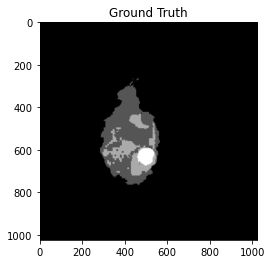

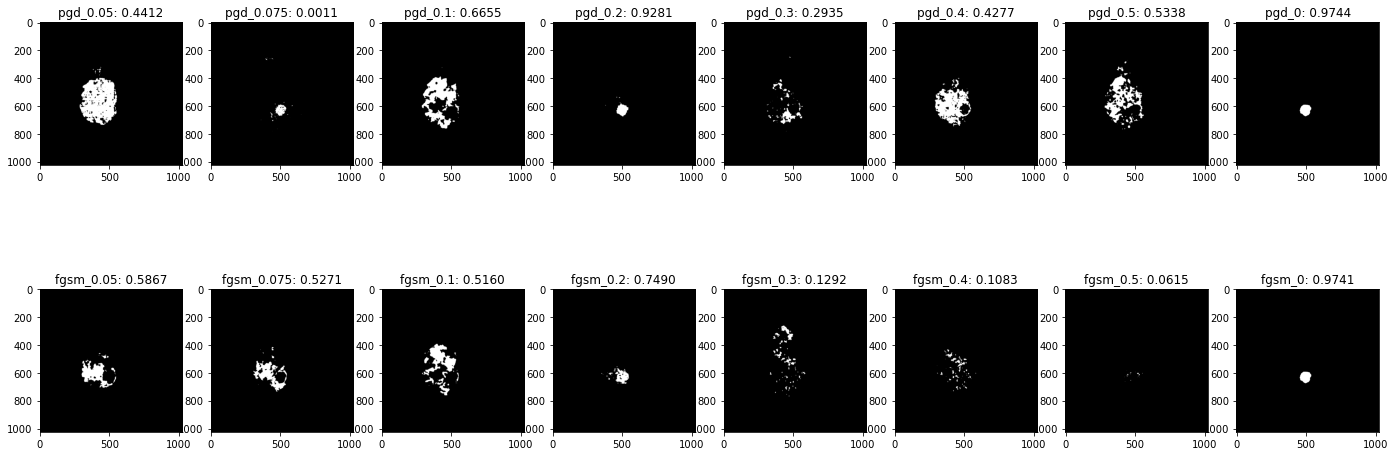

In [19]:
def plot_adv_segmentation(folder_path, file_index=None):
    if file_index is not None:
        file_name = os.listdir(join(folder_path, 'imgs'))[file_index]
    else:
        file_name = random.choice(os.listdir(join(folder_path, 'imgs')))
    
    epsilon_list = [0, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5]
    gt = np.load(join(folder_path, 'gts', file_name))
    plt.imshow(gt, cmap='gray')
    plt.title('Ground Truth')
    
    _, ax = plt.subplots(2, 8, figsize=(24, 9))
    for i, method in enumerate(['pgd', 'fgsm']):
        for j, epsilon in enumerate(epsilon_list):
            
            json_path = join(folder_path, f'{method}_infer', f'eps={epsilon}', f'eps={epsilon}.json')
            with open(json_path, 'r') as f:
                result = json.load(f)
                dice_score = result["metric_per_case"][file_name]
            
            image_infer = np.load(join(folder_path, f'{method}_infer', f'eps={epsilon}', file_name), "r", allow_pickle=True)[0]
            
            ax[i][j-1].imshow(image_infer, cmap='gray')
            ax[i][j-1].set_title(f'{method}_{epsilon}: {dice_score:.4f}')
            
            
file_index = 2
plot_adv_segmentation(all4_file_path, file_index=file_index)

In [20]:
def plot_adv_file_path(folder_path, method='pgd', epsilon=0.1, file_index=None):
    if file_index is not None:
        file_name = os.listdir(join(folder_path, method, f'eps={epsilon}'))[file_index]
    else:
        file_name = random.choice(os.listdir(join(folder_path, method, f'eps={epsilon}')))

    # print(file_name)    
    image = np.load(join(folder_path, method, f'eps={epsilon}', file_name), "r", allow_pickle=True)
    title = f'{method}_{epsilon}_{file_name[-17:]}'

    plot_modalities(image, title)

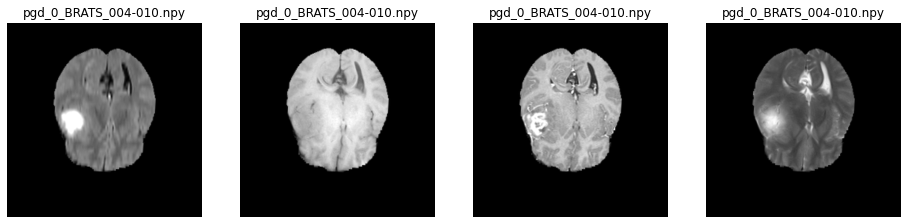

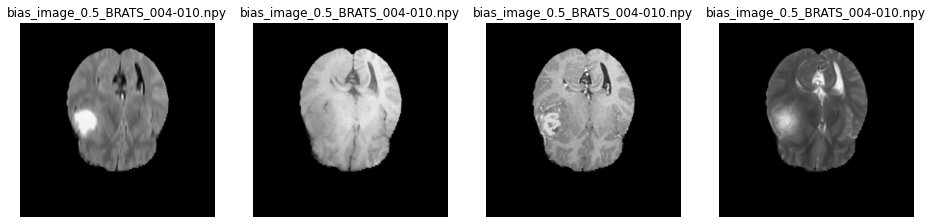

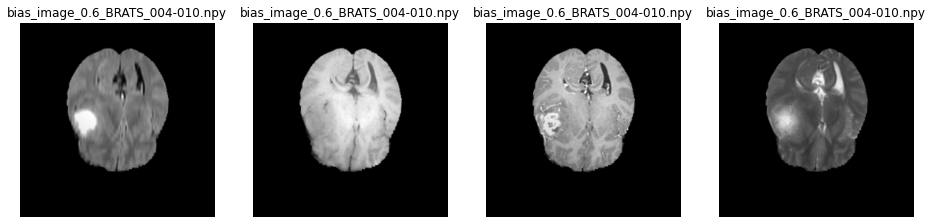

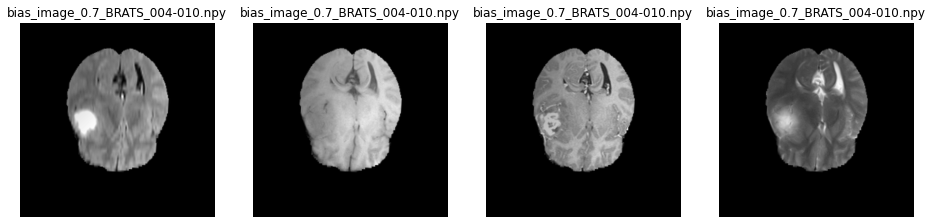

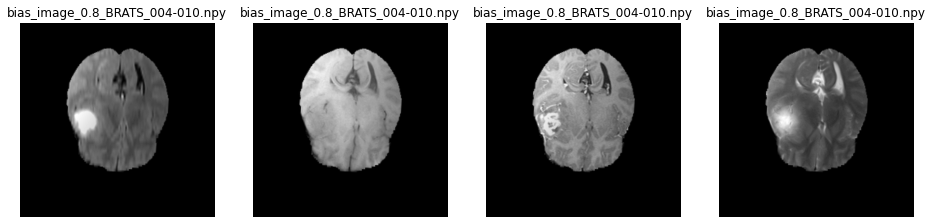

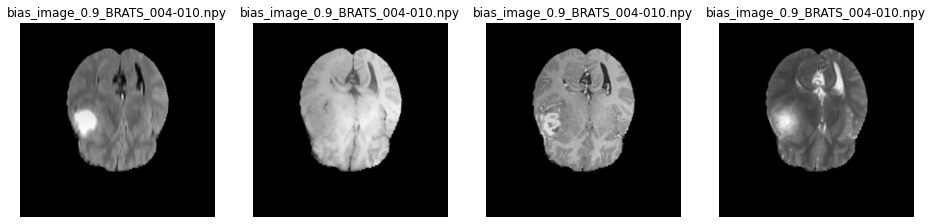

In [32]:
def plot_modalities(image, title='Data'):
    assert isinstance(image, np.ndarray), f'Wrong data type. The data type is {type(image)}, while supposed to be np.ndarray'

    _, axs = plt.subplots(1, 4, figsize=(16, 9))
    for i in range(image.shape[0]):
        img_to_show = image[i]
        axs[i].imshow(img_to_show, cmap='gray')
        axs[i].axis("off")
        # set title
        axs[i].set_title(title)

def plot_adv_file_path(folder_path, method='pgd', epsilon=0.1, file_index=None):
    if file_index is not None:
        file_name = os.listdir(join(folder_path, method, f'eps={epsilon}'))[file_index]
    else:
        file_name = random.choice(os.listdir(join(folder_path, method, f'eps={epsilon}')))

    # print(file_name)    
    image = np.load(join(folder_path, method, f'eps={epsilon}', file_name), "r", allow_pickle=True)
    title = f'{method}_{epsilon}_{file_name[-17:]}'

    plot_modalities(image, title)

file_index = 1
epsilon_list = [0.5, 0.6, 0.7, 0.8, 0.9]

plot_adv_file_path(all4_file_path, method='pgd', epsilon=0, file_index=file_index)

for epsilon in epsilon_list:
    for method in ['bias_image']:
        # method = 'bias_image'
        plot_adv_file_path(all4_file_path, method=method, epsilon=epsilon, file_index=file_index)


In [22]:
sys.path.append('/users/acs23yz/advchain/')

from advchain.augmentor import ComposeAdversarialTransformSolver,AdvBias,AdvMorph,AdvNoise,AdvAffine
from advchain.common.utils import random_chain,load_image_label
from advchain.common.loss import cross_entropy_2D
from advchain.common.vis import plot_warped_grid, plot_noise,plot_bias_field,plot_image,plot_general
from  advchain.models.unet import get_unet_model
from advchain.common.layers import Fixable2DDropout, Fixable3DDropout

In [23]:
crop_size = (1024, 1024)
downscale = 16 # Modify this value to suit the image size

In [24]:
bs=1
im_ch=1
debug = False ## set debug to false to disable intermediate outputs
augmentor_bias= AdvBias(
                 config_dict={'epsilon':0.3,
                 'control_point_spacing':[crop_size[0]//2,crop_size[1]//2],
                 'downscale':downscale,
                 'data_size':(bs,im_ch,crop_size[0],crop_size[1]),
                 'interpolation_order':3,
                 'init_mode':'random',
                 'space':'log'},
                 debug=debug)

                 

augmentor_noise= AdvNoise( config_dict={'epsilon':1,
                'xi':1e-6,
                 'data_size':(bs,im_ch,crop_size[0],crop_size[1])},
                 debug=debug)
    
augmentor_affine= AdvAffine( config_dict={
                 'rot':30.0/180,
                 'scale_x':0.2,
                 'scale_y':0.2,
                 'shift_x':0.1,
                 'shift_y':0.1,
                 'data_size':(bs,im_ch,crop_size[0],crop_size[1]),
                 'forward_interp':'bilinear',
                 'backward_interp':'bilinear'},
                 image_padding_mode="zeros", ## change it other int/float values for padding or other padding mode like "reflection", "border" or "zeros," "zeros" is the default value
                 debug=debug)

augmentor_morph= AdvMorph(
                config_dict=
                {'epsilon':1.5,
                 'data_size':(bs,im_ch,crop_size[0],crop_size[1]),
                 'vector_size':[crop_size[0]//16,crop_size[1]//16],
                 'forward_interp':'bilinear',
                 'backward_interp':'bilinear'
                 }, 
                 image_padding_mode="zeros", ## change it other int/float values for padding or other padding mode like "reflection", "border" or "zeros," "zeros" is the default value
                 debug=debug)

In [25]:
model = medsam_model

In [26]:
## keep model fixed, set up a solver
model.eval()
transformation_chain = [augmentor_noise,augmentor_bias,augmentor_morph,augmentor_affine] ## specify an order: noise->bias->morph->affine
# transformation_chain = [augmentor_affine,augmentor_morph,augmentor_bias,augmentor_noise] ## specify an order: noise->bias->morph->affine

solver = ComposeAdversarialTransformSolver(
        chain_of_transforms=transformation_chain,
        divergence_types = ['mse','contour'], ### you can also change it to 'kl'.
        divergence_weights=[1.0,0.5],
        use_gpu= False,
        debug=True,
        if_norm_image=True
       )

In [27]:
slice_id=0
solver.init_random_transformation()
rand_transformed_image = solver.forward(image_tensor.detach().clone())
rand_predict = solver.get_net_output(model,rand_transformed_image)
warp_back_rand_predict= solver.predict_backward(rand_predict)

rand_bias = augmentor_bias.bias_field
rand_noise = augmentor_noise.param
rand_dxy,rand_morph = augmentor_morph.get_deformation_displacement_field(-augmentor_morph.param)
rand_deformed_image =augmentor_morph.transform((image_tensor+rand_noise)*rand_bias,rand_dxy, interp=augmentor_morph.forward_interp).cpu().data.numpy()[slice_id,0]

loss = solver.adversarial_training(
        data=image_tensor,model=model,
        n_iter=1,
        lazy_load=[True]*len(transformation_chain), ## if set to true, it will use the previous sampled random bias field as initialization.
        optimize_flags=[True]*len(transformation_chain),
        step_sizes=1,power_iteration=[False]*len(transformation_chain))

adv_bias= augmentor_bias.bias_field
adv_noise = augmentor_noise.param
adv_dxy,adv_morph = augmentor_morph.get_deformation_displacement_field(-augmentor_morph.param)
adv_transformed_image = solver.forward(image_tensor.detach().clone())
adv_predict =  solver.get_net_output(model,adv_transformed_image)
warp_back_adv_predict= solver.predict_backward(adv_predict)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
# bbox = np.array([[247., 381., 494., 637.]])

# for epsilon in range(1, 6):
#     epsilon /= 10
#     for method in ['pgd', 'fgsm']:
#         image = np.load(join(all4_file_path, method, f'eps={epsilon}', 'all_Brain_BRATS_016-006.npy'))
#         prediction = medsam_model(image, bbox)

        

In [ ]:
for epsilon in range(1, 6):
    epsilon /= 10
    print(f'Now the epsilon is {epsilon}')
    for adv_method in ['pgd', 'fgsm']:
        adv_path = f'{adv_method}/eps={epsilon}/'
        pred_dataset = NpyDataset(all4_file_path, epsilon=epsilon, adv_method=adv_method)
        print("Number of training samples: ", len(pred_dataset))
        pred_dataloader = DataLoader(
            pred_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=True,
        )
        
        dice_loss = {}
        dice_loss['adv_method'] = adv_method
        dice_loss['epsilon'] = epsilon
        dice_loss['metric_per_case'] =  {}
        
        for step, (image, gt2D, boxes, names_temp) in enumerate(tqdm(pred_dataloader)):
            optimizer.zero_grad()
            boxes_np = boxes.detach().cpu().numpy()

            image, gt2D = image.to(device), gt2D.to(device)
            
            prediction = medsam_model(image, boxes_np)
            segmentation = predicted_logits_to_segmentation(prediction)
            
            dice = compute_metrics(segmentation, gt2D)
            
            for idx in range(image.shape[0]):
                save_tensor_as_npy(segmentation[idx], join(all4_file_path, f'{adv_method}_infer', f'eps={epsilon}', names_temp[idx]))
                print(f'Dice loss of {names_temp[idx]}: {dice[idx]}')
                dice_loss['metric_per_case'][names_temp[idx]] = dice[idx]
                
        dice_loss['mean'] = np.mean(list(dice_loss['metric_per_case'].values()))

        json_path = join(all4_file_path, f'{adv_method}_infer', f'eps={epsilon}', f'eps={epsilon}.json')
        os.makedirs(os.path.dirname(json_path), exist_ok=True)
        with open(json_path, 'w') as json_file:
            json.dump(dice_loss, json_file)

        print(f"Dice loss for epsilon {epsilon} saved to {json_path}")


        

Now the epsilon is 0.1
number of images: 2550
Number of training samples:  2550


  0%|▏                                                                                                                                                                                                                                                      | 1/1275 [00:11<3:55:06, 11.07s/it]

Tensor saved as /mnt/parscratch/users/acs23yz/MedSAM/data/npy/all_Brain/pgd_infer/eps=0.1/all_Brain_BRATS_036-058.npy
Dice loss of all_Brain_BRATS_036-058.npy: 0.38509316770186336
Tensor saved as /mnt/parscratch/users/acs23yz/MedSAM/data/npy/all_Brain/pgd_infer/eps=0.1/all_Brain_BRATS_003-060.npy
Dice loss of all_Brain_BRATS_003-060.npy: 0.9293286844480628


  0%|▍                                                                                                                                                                                                                                                      | 2/1275 [00:20<3:34:48, 10.12s/it]

Tensor saved as /mnt/parscratch/users/acs23yz/MedSAM/data/npy/all_Brain/pgd_infer/eps=0.1/all_Brain_BRATS_020-020.npy
Dice loss of all_Brain_BRATS_020-020.npy: 0.7163299663299664
Tensor saved as /mnt/parscratch/users/acs23yz/MedSAM/data/npy/all_Brain/pgd_infer/eps=0.1/all_Brain_BRATS_015-000.npy
Dice loss of all_Brain_BRATS_015-000.npy: 0.07154605263157894


  0%|▌                                                                                                                                                                                                                                                      | 3/1275 [00:29<3:25:38,  9.70s/it]

Tensor saved as /mnt/parscratch/users/acs23yz/MedSAM/data/npy/all_Brain/pgd_infer/eps=0.1/all_Brain_BRATS_017-022.npy
Dice loss of all_Brain_BRATS_017-022.npy: 0.7489152555389164
Tensor saved as /mnt/parscratch/users/acs23yz/MedSAM/data/npy/all_Brain/pgd_infer/eps=0.1/all_Brain_BRATS_034-064.npy
Dice loss of all_Brain_BRATS_034-064.npy: 0.24860853432282004


  0%|▌                                                                                                                                                                                                                                                      | 3/1275 [00:37<4:28:05, 12.65s/it]


KeyboardInterrupt: 

(1, 1024, 1024)


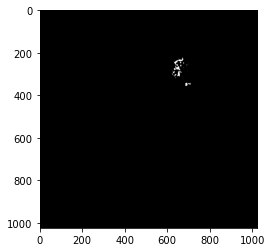

In [ ]:
img = np.load('/mnt/parscratch/users/acs23yz/MedSAM/data/npy/all_Brain/pgd_infer/eps=0.1/all_Brain_BRATS_008-068.npy')
print(img.shape)

plt.imshow(img[0], cmap='gray')